In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import glob
import math
import time
import cv2
import sys
import os

import tifffile as tiff

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from typing import List, Callable, Union, Any, TypeVar, Tuple

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn

sns.set_theme(style = "white")

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

## U-Net Model

In [2]:
def ConvBlock(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True)
    )

def FinalBlock(in_channels, out_channels):
    return nn.Sequential(
        #ConvBlock(in_channels, in_channels,  kernel_size = 1),
        ConvBlock(in_channels, in_channels,  kernel_size = 1, stride = 1, padding = 0),
        nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0)
    )

def MiddleBlock(in_channels, out_channels):
    return nn.Sequential(
        ConvBlock(in_channels, out_channels),
        nn.Dropout(p = 0.2),
        ConvBlock(out_channels, out_channels)
    )

class ResidualBlock(nn.Module):
    """ Residual encoder block. """
    def __init__(self, in_channels, feature_maps, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()

        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = (2, 2), stride = None)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, feature_maps, kernel_size = (1, 1), stride = stride, bias = False),
            nn.BatchNorm2d(feature_maps)
        )

        self.conv1 = nn.Conv2d(in_channels, feature_maps,  kernel_size = (3, 3), stride = stride, padding = 1, bias = False)
        self.bn1   = nn.BatchNorm2d(feature_maps)

        self.conv2 = nn.Conv2d(feature_maps, feature_maps, kernel_size = (3, 3), stride = 1,      padding = 1, bias = False)
        self.bn2   = nn.BatchNorm2d(feature_maps)

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x = x + identity

        skip_connection = self.relu(x)

        x = self.maxpool(skip_connection)

        return x, skip_connection

class Encoder(nn.Module):
    def __init__(self, in_channels):
        super(Encoder, self).__init__()

        self.Encoder_0 = ResidualBlock(in_channels = in_channels, feature_maps = 32)
        self.Encoder_1 = ResidualBlock(in_channels = 32,          feature_maps = 64)
        self.Encoder_2 = ResidualBlock(in_channels = 64,          feature_maps = 128)

        self.Middle = MiddleBlock(in_channels = 128, out_channels = 256)

    def forward(self, x):
        x, x0 = self.Encoder_0(x)
        x, x1 = self.Encoder_1(x)
        x, x2 = self.Encoder_2(x)

        x3 = self.Middle(x)

        return [x0, x1, x2, x3]
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()

        self.up = nn.Upsample(scale_factor = 2)

        self.conv_block_0 = ConvBlock(in_channels + out_channels, out_channels)
        self.conv_block_1 = ConvBlock(out_channels, out_channels)

    def forward(self, x, skip_connection):
        x = self.up(x)

        x = torch.cat((x, skip_connection), 1)

        x = self.conv_block_0(x)
        x = self.conv_block_1(x)

        return x
    
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super(Decoder, self).__init__()

        self.decoder_0 = DecoderBlock(256, 128) 
        self.decoder_1 = DecoderBlock(128, 64)
        self.decoder_2 = DecoderBlock(64, 32)
        
        self.FinalBlock = FinalBlock(in_channels = 32, out_channels = out_channels)
        
    def forward(self, x0, x1, x2, x3):
        x = self.decoder_0(x3, x2)
        x = self.decoder_1(x,  x1)
        x = self.decoder_2(x,  x0)
        
        x = self.FinalBlock(x)

        return x 

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels = 1):
        super(UNet, self).__init__()

        self.backbone = Encoder(in_channels)
        self.head     = Decoder(out_channels)
        
    def forward(self, x):
        x0, x1, x2, x3 = self.backbone(x)

        x = self.head(x0, x1, x2, x3)

        return x


In [5]:
model = UNet(1)

# Verify output size is as expected.
model(torch.rand(2, 1, 512, 512)).shape

torch.Size([2, 1, 512, 512])

## Loss Function

In [6]:
class DiceLoss(nn.Module):
    """
    Binary dice loss for semantic segmentation. This code is reworked from
    these GitHub repos:
        - https://github.com/qubvel/segmentation_models.pytorch
        - https://github.com/BloodAxe/pytorch-toolbelt

    """
    def __init__(self, from_logits = True, log_loss = False, smooth = 0.0, eps = 1e-7):
        """
        Args:
            log_loss (bool): If True, the loss is computed as `-log(dice_coeff)`,
                otherwise `1 - dice_coeff`.

            from_logits (bool): If True, assumes y_pred are raw logits.
            smooth (float): Smoothness constant for dice coefficient.
            eps (float): For numerical stability to avoid zero division error.

        """
        super(DiceLoss, self).__init__()

        self.from_logits = from_logits
        self.log_loss = log_loss
        self.smooth = smooth
        self.eps = eps

    def forward(self, y_pred, y_true):
        """
        Args:
            y_pred (torch.Tensor): Of shape (B, C, H, W).
            y_true (torch.Tensor): Of shape (B, C, H, W).

        Returns:
            torch.Tensor: The loss.

        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            y_pred = F.logsigmoid(y_pred).exp()

        bs   = y_true.size(0)
        dims = (0, 2)

        y_true = y_true.view(bs, 1, -1)
        y_pred = y_pred.view(bs, 1, -1)

        scores = self._compute_score(
            y_pred, 
            y_true.type_as(y_pred), 
            smooth = self.smooth, 
            eps = self.eps, 
            dims = dims
        )

        if self.log_loss: loss = -torch.log(scores.clamp_min(self.eps))
        else:             loss = 1.0 - scores

        mask = y_true.sum(dims) > 0
        loss = loss * mask.to(loss.dtype)

        return self._reduction(loss)

    def _reduction(self, loss):
        return loss.mean()

    def _compute_score(self, y_pred, y_true, smooth = 0.0, eps = 1e-7, dims = ()):
        assert y_pred.size() == y_true.size()

        intersection = torch.sum(y_pred * y_true, dim = dims)
        cardinality = torch.sum(y_pred + y_true, dim = dims)

        dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)

        return dice_score


class TverskyLoss(DiceLoss):
    """
    This code is reworked from this GitHub repo:
        - https://github.com/qubvel/segmentation_models.pytorch
        - https://github.com/BloodAxe/pytorch-toolbelt

    Tversky loss for semantic segmentation. Notice this class inherits
    `DiceLoss` and adds a weight to the value of each TP and FP given by
    constants alpha and beta. With alpha == beta == 0.5, this loss becomes
    equal to the Dice loss. `y_pred` and `y_true` must be torch tensors of
    shape (B, C, H, W).

    """
    def __init__(self, from_logits = True, log_loss = False, smooth = 0.0, eps = 1e-7, 
                 alpha = 0.5, beta = 0.5, gamma = 1.0):
        """
        Args:
            from_logits (bool): If True, assumes y_pred are raw logits.
            log_loss (bool): If True, the loss is computed as `-log(dice_coeff)`,
                otherwise `1 - dice_coeff`.

            smooth (float): Smoothness constant for dice coefficient.
            eps (float): For numerical stability to avoid zero division error.
            alpha (float): Weight constant that penalize model for FPs.
            beta (float): Weight constant that penalize model for FNs.
            gamma (float): Constant that squares the error function. Defaults to `1.0`.

        """
        super(TverskyLoss, self).__init__(from_logits, log_loss, smooth, eps)

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def _reduction(self, loss):
        return loss.mean() ** self.gamma

    def _compute_score(self, y_pred, y_true, smooth = 0.0, eps = 1e-7, dims = ()):
        assert y_pred.size() == y_true.size()

        intersection = torch.sum(y_pred * y_true, dim = dims)  
        fp = torch.sum(y_pred * (1.0 - y_true), dim = dims)
        fn = torch.sum((1 - y_pred) * y_true, dim = dims)

        tversky_score = (intersection + smooth) / (intersection + self.alpha * fp + self.beta * fn + smooth).clamp_min(eps)

        return tversky_score
    

In [7]:
""" For EDA, not needed when training.
images = []
for image_dir in sorted(glob.glob("Unet-skin_skull/Original/*.tif")):
    images.append(
        tiff.imread(image_dir).astype(np.float32)
    )
    
images = np.array(images)

images.shape
"""

In [ ]:
""" For EDA, not needed when training.
count_skin = 0
count_total = 0
for mask_dir in sorted(glob.glob("Unet-skin_skull/merged_masks/*.tif")):
    count_total += 1
    
    mask = tiff.imread(mask_dir).astype(np.float32)
    if np.any(mask == 2):
        count_skin += 1

print(count_skin)
print(count_total)
print(count_skin / count_total)
"""

## Dataset

In [6]:
def preprocess_image(image, max_value = 65_533):
    """ Normalize values between -1 and 1. """
    return ((image / max_value) - 1) * 2

class ZahraDataset(Dataset):
    def __init__(self,         
        data_dir: str, 
        transformations = None,
        remove_ids: List[int] = [], 
        image_path: str = "images/*.tif", 
        mask_path: str = "masks/*.tif"
    ): 
        self.images_dir = sorted(glob.glob(os.path.join(data_dir, image_path)))
        self.masks_dir  = sorted(glob.glob(os.path.join(data_dir, mask_path)))
        self.transformations = transformations
        
        self.masks = []
        self.images = []
        for i, (image_dir, mask_dir) in enumerate(zip(self.images_dir, self.masks_dir)):
            if i not in remove_ids:
                image = tiff.imread(image_dir).astype(np.float32)[:, :, None]
                mask  = tiff.imread(mask_dir).astype(np.float32)[:, :, None]
                
                # Currently I am removing the skin all together.
                mask[mask == 2] = 0

                image = preprocess_image(image)
                
                # Also, do to the class imbalance, anytime there is
                # skin present I double it in the training set.
                if np.any(mask == 2):
                    self.images.append(image)
                    self.masks.append(mask)
                    
                self.images.append(image)
                self.masks.append(mask)

    def __getitem__(self, idx):
        mask  = self.masks[idx]
        image = self.images[idx]
        if self.transformations is not None:
            transformed = self.transformations(image = image, mask = mask)
            image = transformed["image"]
            mask  = transformed["mask"]
                    
        return image, mask

    def __len__(self):
        return len(self.images)
    

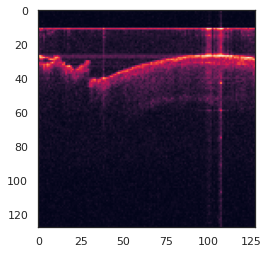

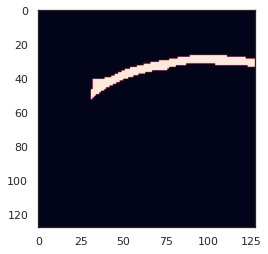

In [11]:
from albumentations.core.transforms_interface import DualTransform
import random

def shift_image_vertical(img, amount):
    return np.roll(img, amount, axis = 0)

class RandomVerticalShift(DualTransform):
    """Randomly shift the data horizontally.

    Args:
        max_shift (int): The maximum amount of shift possible.
        p (float): probability of applying the transform. Default: 1.

    Targets:
        image, mask, bboxes, keypoints

    Image types:
        uint8, float32
        
    """
    def __init__(self, max_shift = [0, 0], always_apply = False, p = 0.5):
        super().__init__(always_apply, p)
        self.max_shift = max_shift

    def apply(self, img, **params):
        return shift_image_vertical(img, params["shift"])
    
    def get_params(self):
        return {"shift": np.random.randint(self.max_shift[0], self.max_shift[1])}
    
    def get_transform_init_args_names(self):
        return ("max_shift")

    
image = tiff.imread("OCT_scans_128x128/test/images/train-P (1).tif")[:, :, None]
mask = tiff.imread("OCT_scans_128x128/test/masks/train-P (1).tif")[:, :, None]

trans = RandomVerticalShift(p = 1.0, max_shift = [-12, 64])
out = trans(image = image, mask = mask)

plt.imshow(out["image"])
plt.show()
plt.imshow(out["mask"])
plt.show()

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transformations = A.Compose([
    RandomVerticalShift(p = 0.5, max_shift = [-12, 256]),
    A.ElasticTransform(p = 0.2, alpha_affine = 25, border_mode = cv2.BORDER_REFLECT),
    A.VerticalFlip(p = 1.0 / 3.0),
    A.HorizontalFlip(p = 1.0 / 3.0),
    ToTensorV2(transpose_mask = True),
])

In [10]:
old_data = False

if old_data:
    data_dir = "OCT_scans_128x128/"

    train_dir = os.path.join(data_dir, "train/")
    test_dir  = os.path.join(data_dir, "test/")
    val_dir   = os.path.join(data_dir, "val/")
else:
    train_dir = "Unet-skin_skull/"

In [11]:
class cfg:
    BATCH_SIZE = 4
    EPOCHS = 100
    LOG_EVERY = 3
    DEVICE = "cuda"


In [22]:
model = UNet(1, 1).to(cfg.DEVICE)

loss_function_0 = TverskyLoss(from_logits = True)
loss_function_1 = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.0003)

In [13]:
# I hand went through the dataset, these are the indices to remove from the
# training set. And the id's of each image, but for now I am just using indices
# after sorting cause I'm lazy.

#remove_train_indexs = [6,  9, 11, 13, 16, 18, 19, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 40, 41, 44, 48, 52]
#remove_train_ids    = [17, 2, 21, 23, 26, 29, 3,  32, 34, 36, 28, 39, 40, 41, 43, 44, 45, 49, 58, 59, 63, 7,  8 ]

In [23]:
#train_dataset = ZahraDataset(train_dir, remove_train_indexs)
train_dataset = ZahraDataset(
    train_dir, 
    transformations = transformations, 
    image_path = "Original/*.tif", 
    mask_path = "merged_masks/*.tif"
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size = cfg.BATCH_SIZE,
    pin_memory = True,
    drop_last = True,
    shuffle = True,
    num_workers = 4
)

ITERS = len(train_dataloader)
delimiter = " | "

model.train(True)
total_time = time.time()
for epoch in range(1, cfg.EPOCHS + 1):
    epoch_time = time.time()
    
    for step, (images, masks) in enumerate(train_dataloader, 1):
        step_time = time.time()
        
        # Reduces the number of memory operations. 
        for param in model.parameters():
            param.grad = None
        
        images = images.to(cfg.DEVICE)
        masks = masks.to(cfg.DEVICE)
        
        pred = model(images)
        #pred = torch.sigmoid(pred))
        
        loss = loss_function_0(pred, masks) #+ loss_function_1(pred, masks)

        loss.backward()
        optimizer.step()
        
        if step % cfg.LOG_EVERY == 0:
            curr_time = time.time()
            print(delimiter.join([
                f"Epoch: [{epoch:>{len(str(cfg.EPOCHS))}}/{cfg.EPOCHS}]", 
                f"Step: [{step:>{len(str(ITERS))}}/{ITERS}]",
                f"Step Time: {curr_time - step_time:.4f}",
                f"Total Time: {curr_time - total_time:.4f}",
                f"Tversky Loss: {loss.item():.4f}"
            ]))
            

Epoch: [  1/100] | Step: [ 3/32] | Step Time: 0.2950 | Total Time: 1.1573 | Tversky Loss: 0.8893
Epoch: [  1/100] | Step: [ 6/32] | Step Time: 0.2918 | Total Time: 2.0565 | Tversky Loss: 0.8552
Epoch: [  1/100] | Step: [ 9/32] | Step Time: 0.2859 | Total Time: 2.9450 | Tversky Loss: 0.8343
Epoch: [  1/100] | Step: [12/32] | Step Time: 0.2911 | Total Time: 3.8415 | Tversky Loss: 0.7978
Epoch: [  1/100] | Step: [15/32] | Step Time: 0.2981 | Total Time: 4.7364 | Tversky Loss: 0.7981
Epoch: [  1/100] | Step: [18/32] | Step Time: 0.3022 | Total Time: 5.6287 | Tversky Loss: 0.7996
Epoch: [  1/100] | Step: [21/32] | Step Time: 0.2974 | Total Time: 6.5143 | Tversky Loss: 0.8203
Epoch: [  1/100] | Step: [24/32] | Step Time: 0.2955 | Total Time: 7.4060 | Tversky Loss: 0.7671
Epoch: [  1/100] | Step: [27/32] | Step Time: 0.2946 | Total Time: 8.2979 | Tversky Loss: 0.7823
Epoch: [  1/100] | Step: [30/32] | Step Time: 0.2976 | Total Time: 9.1908 | Tversky Loss: 0.8063
Epoch: [  2/100] | Step: [ 3/3

In [17]:
#test_dataset = ZahraDataset(test_dir)
#test_dataloader = DataLoader(
#    train_dataset,
#    batch_size = 1,
#    pin_memory = True,
#    drop_last = True,
#    shuffle = True,
#    num_workers = 4
#)

test_dataset = ZahraDataset(
    train_dir,
    transformations = ToTensorV2(transpose_mask = True), 
    image_path = "Original/*.tif", 
    mask_path = "merged_masks/*.tif"
)

In [ ]:
for step, (image, mask) in enumerate(test_dataset, 1):
    fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize = (15, 25))
    ax_0.imshow(image[0])
    ax_1.imshow(mask)
    plt.show()


In [20]:
from skimage import measure

def remove_small_components(binary_image, area):
    # Find connected components in binary image.
    labels = measure.label(binary_image)

    # Find indices of connected components with area under given size
    small_components_indices = np.where([np.sum(labels == label) < area for label in np.unique(labels)])

    # Remove small connected components
    labels[np.isin(labels, small_components_indices)] = 0
    
    return labels.astype(np.bool)

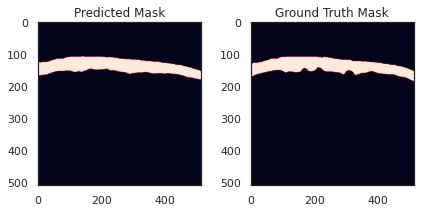

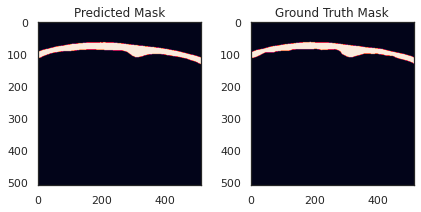

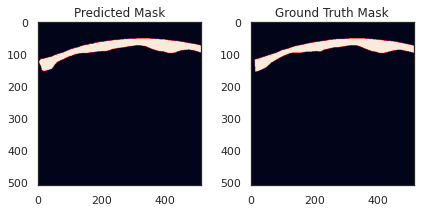

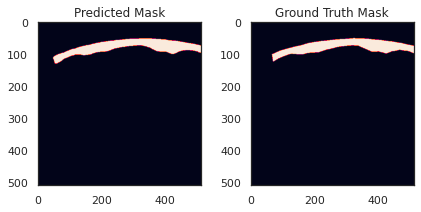

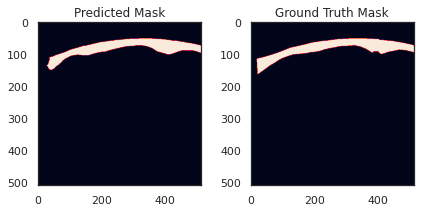

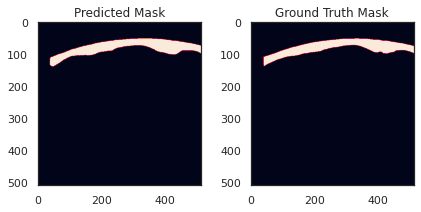

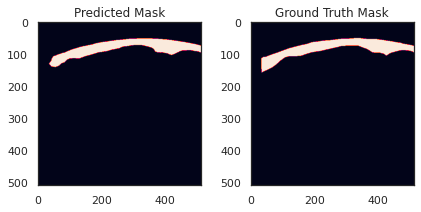

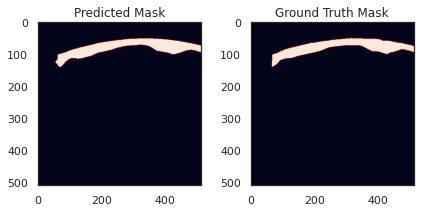

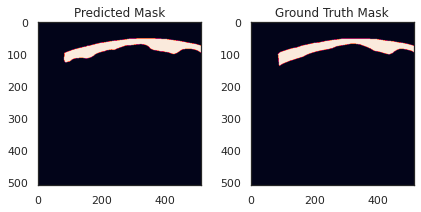

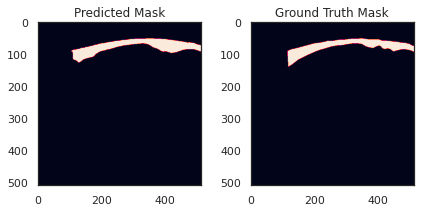

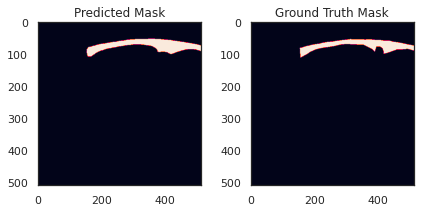

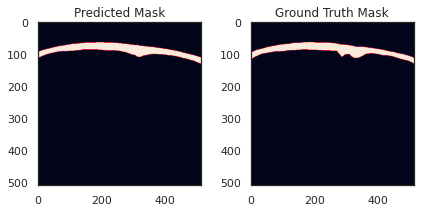

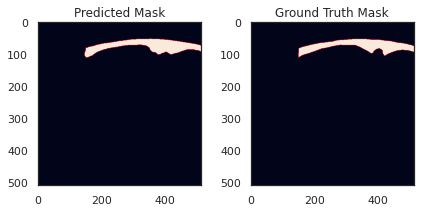

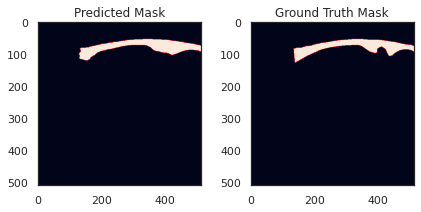

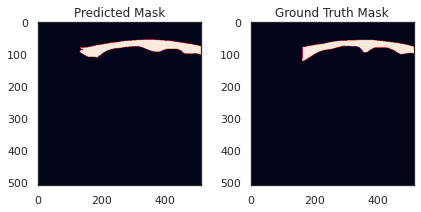

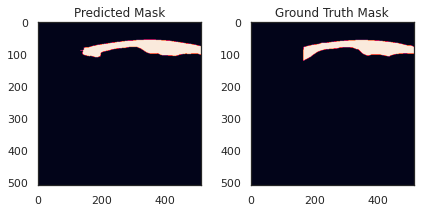

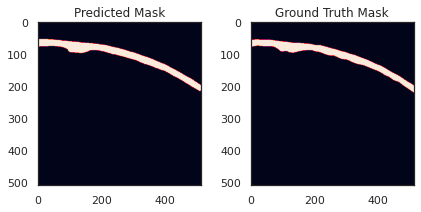

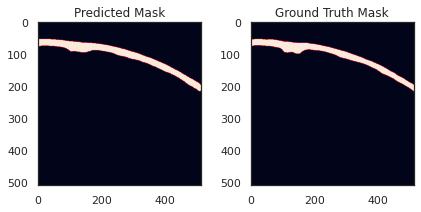

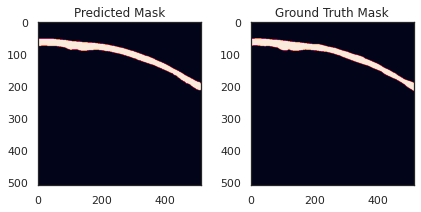

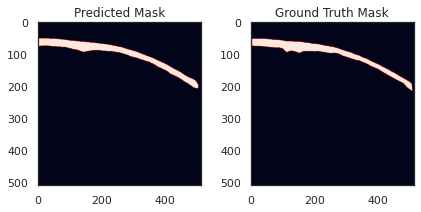

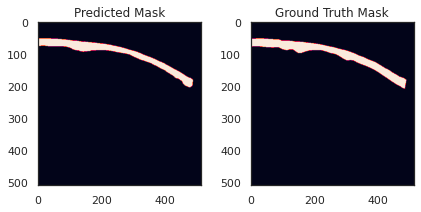

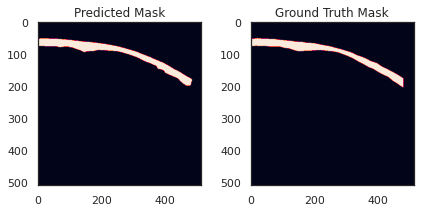

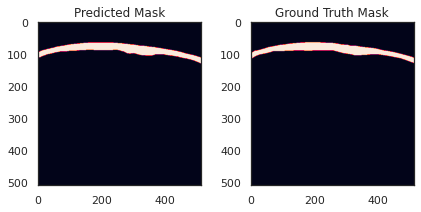

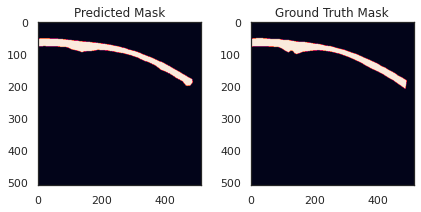

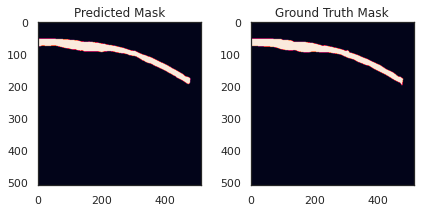

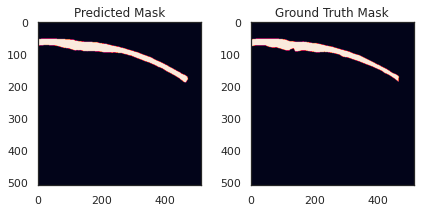

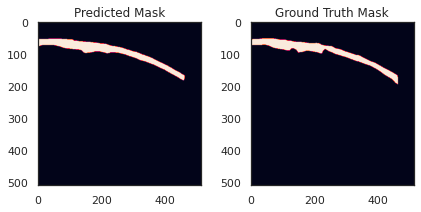

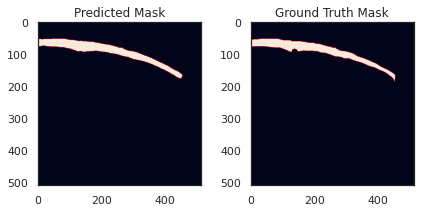

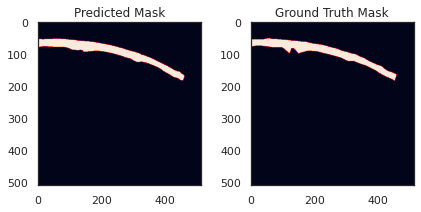

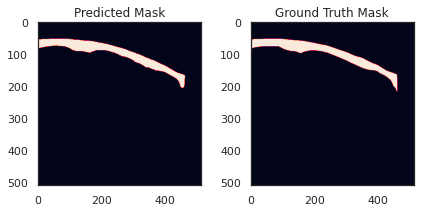

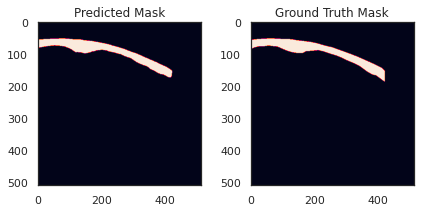

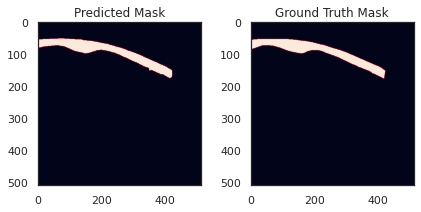

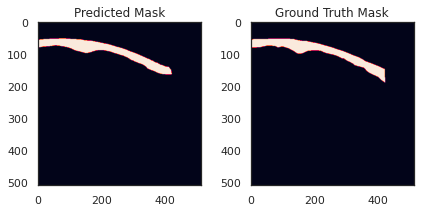

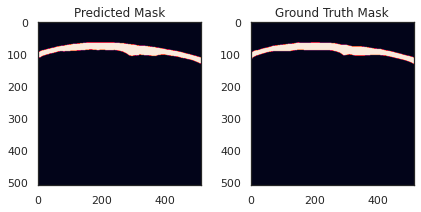

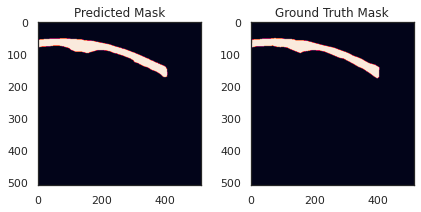

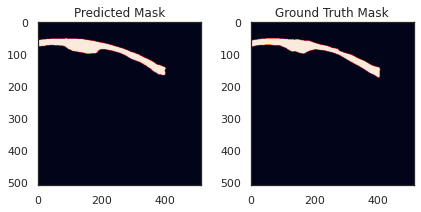

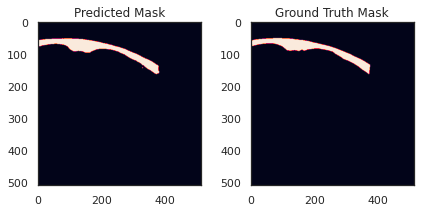

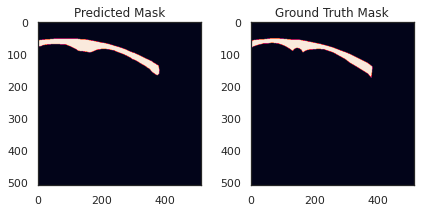

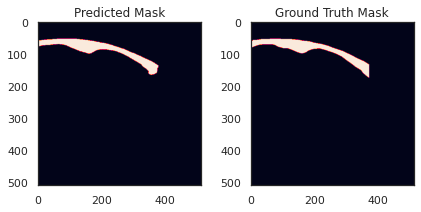

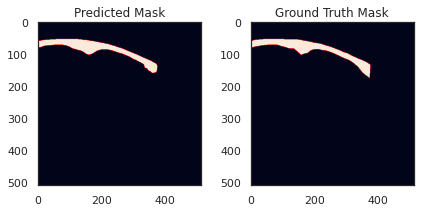

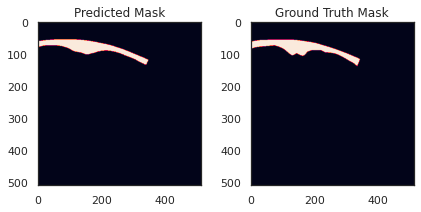

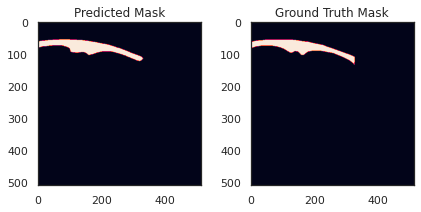

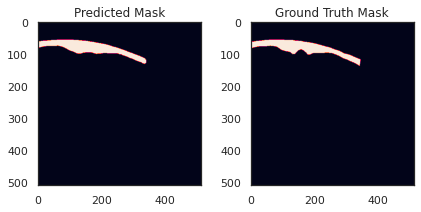

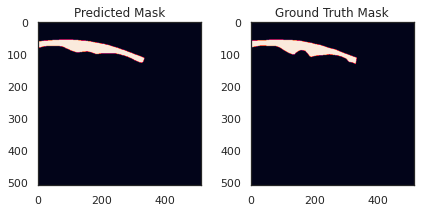

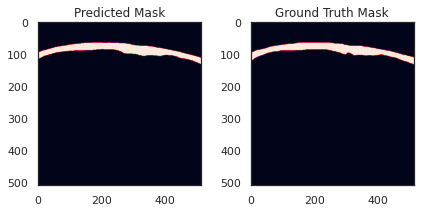

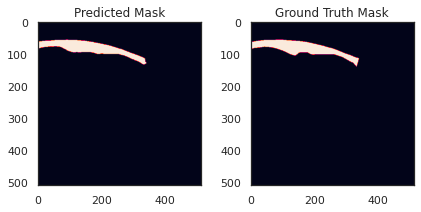

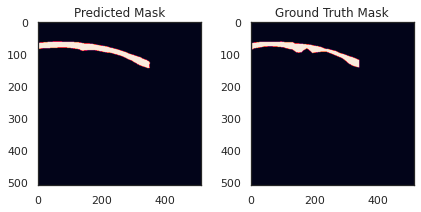

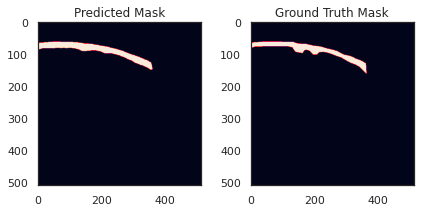

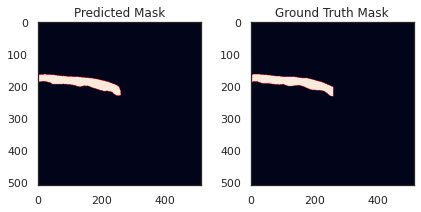

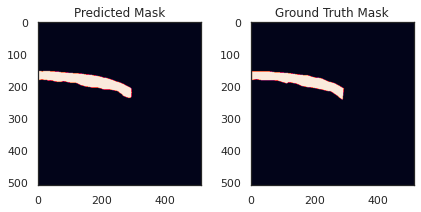

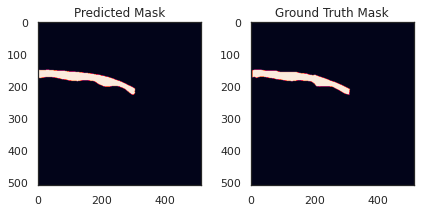

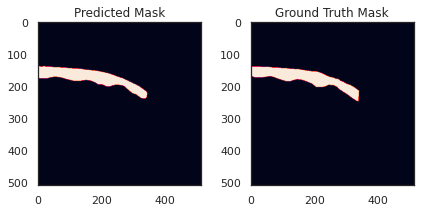

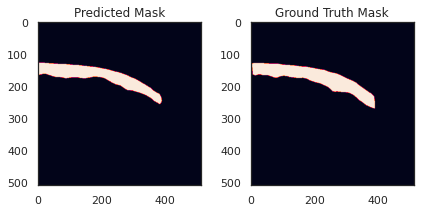

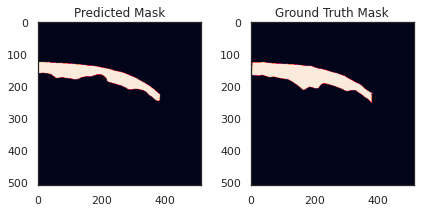

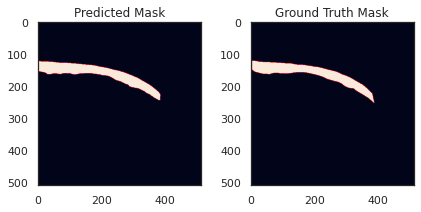

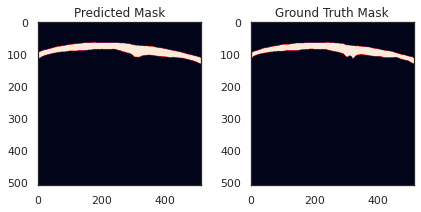

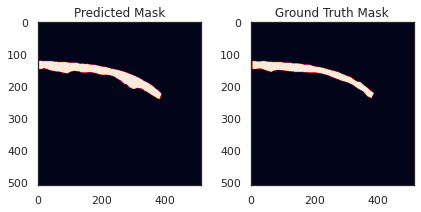

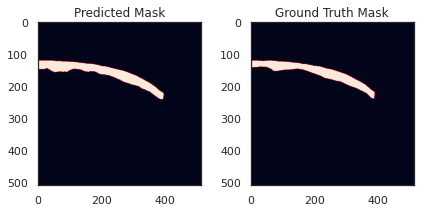

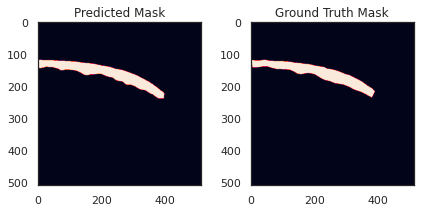

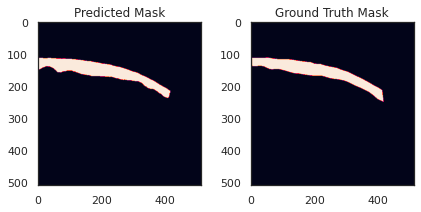

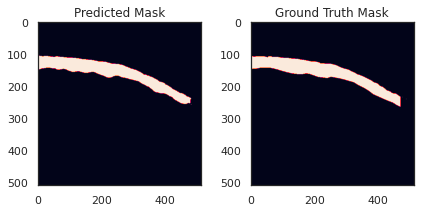

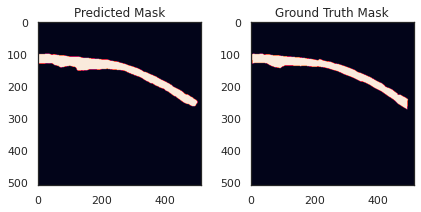

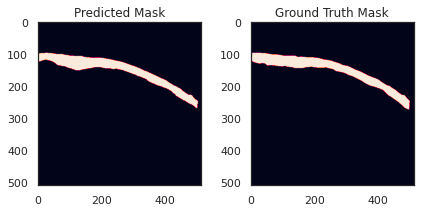

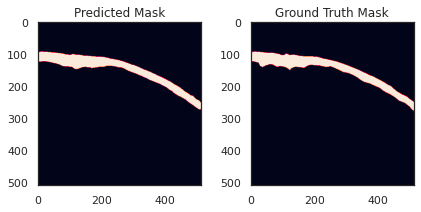

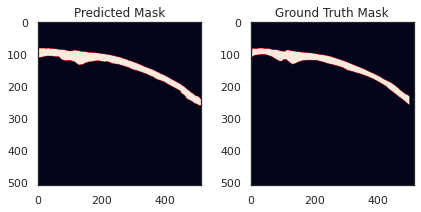

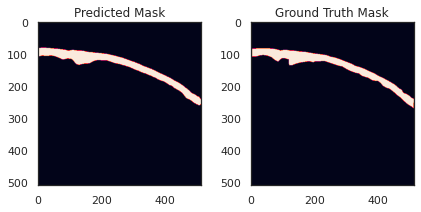

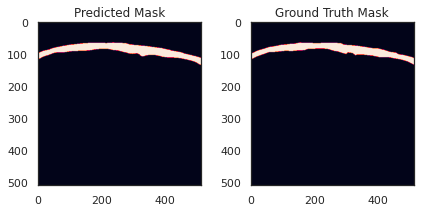

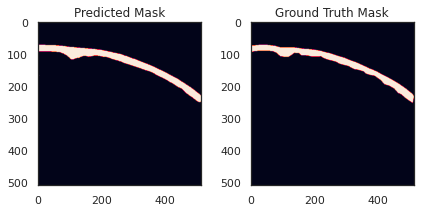

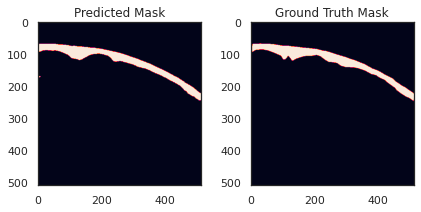

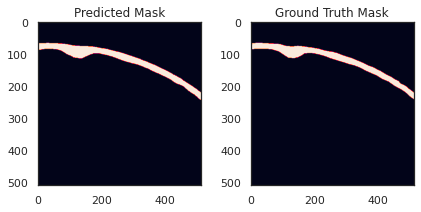

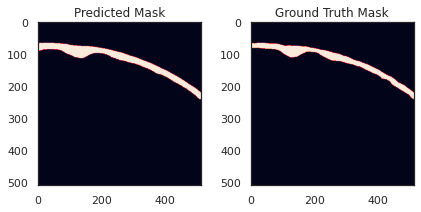

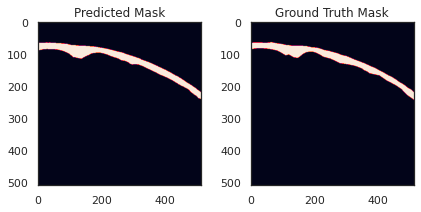

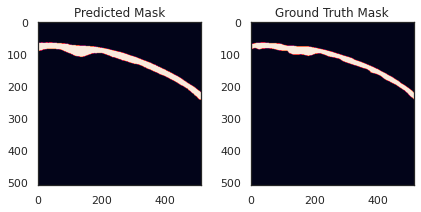

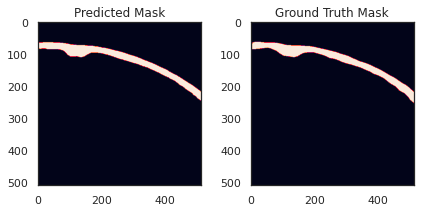

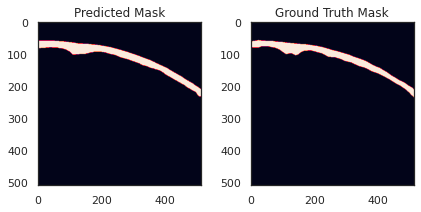

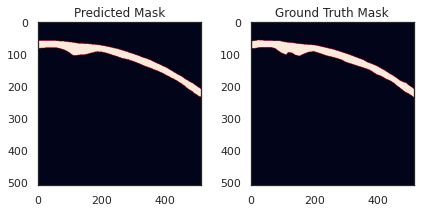

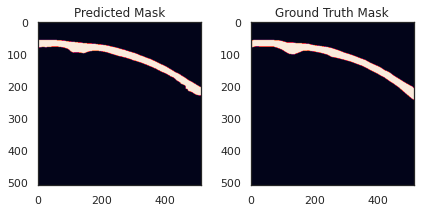

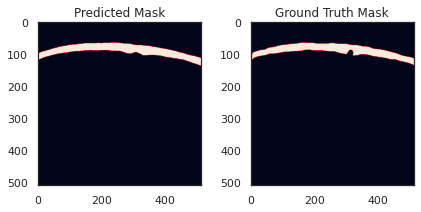

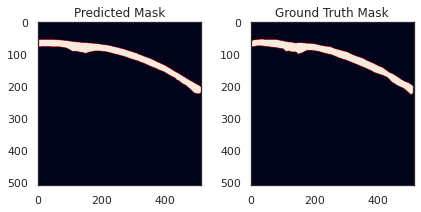

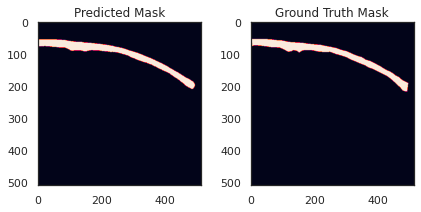

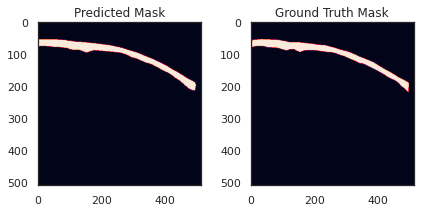

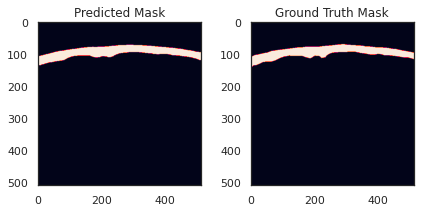

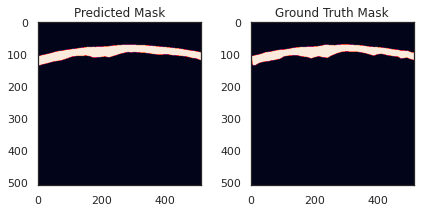

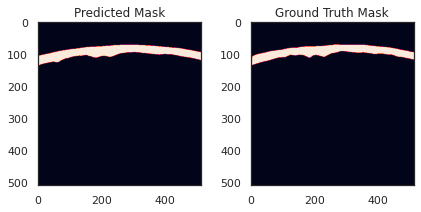

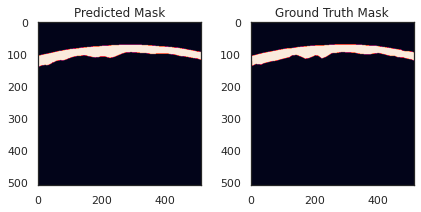

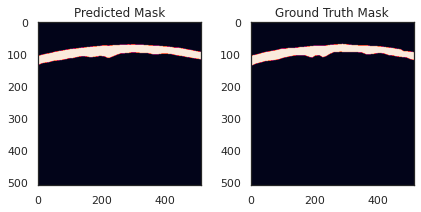

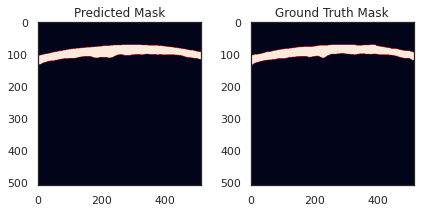

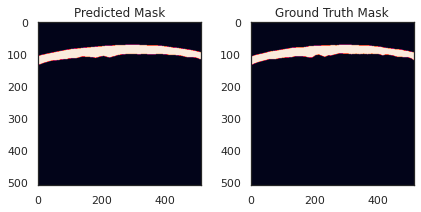

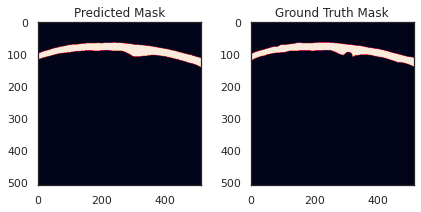

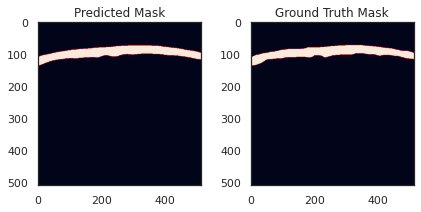

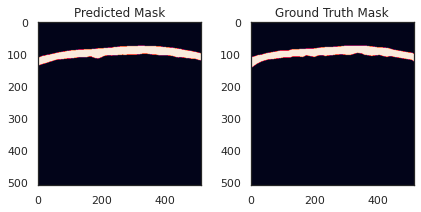

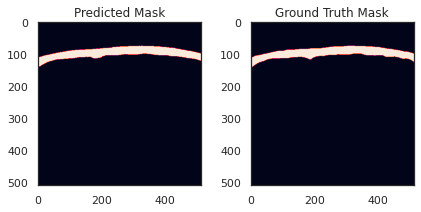

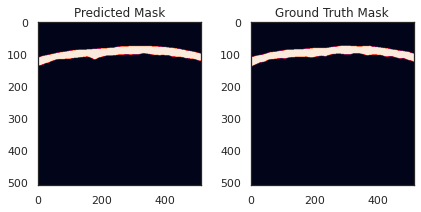

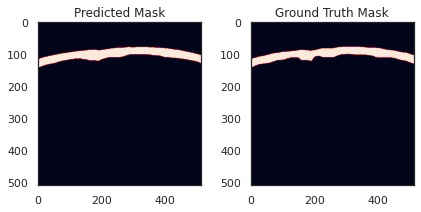

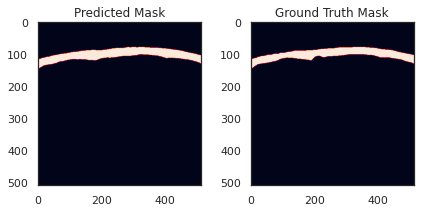

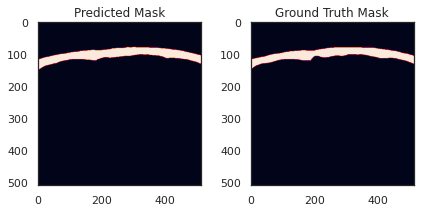

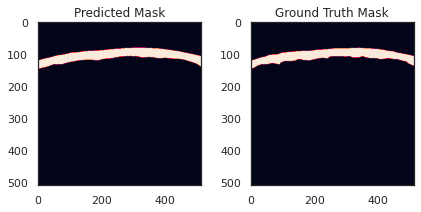

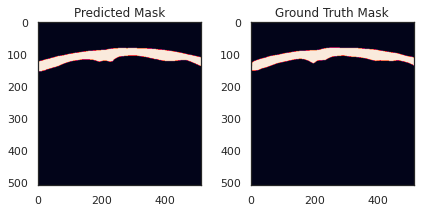

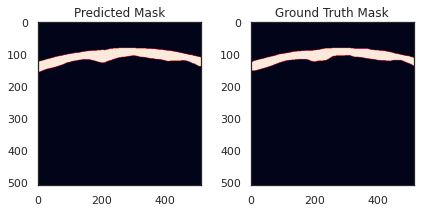

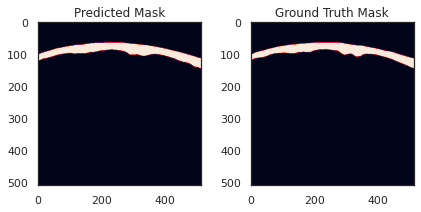

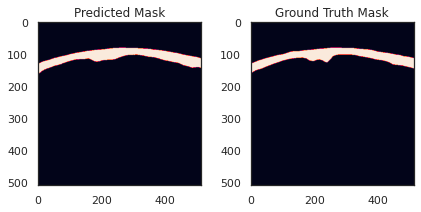

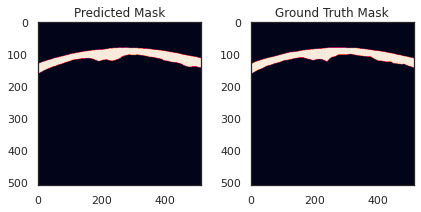

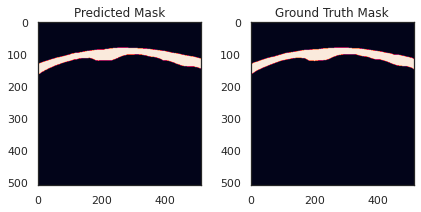

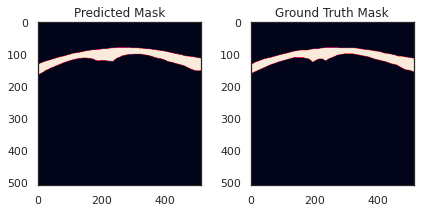

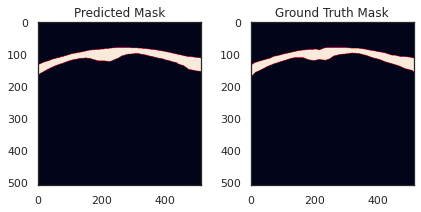

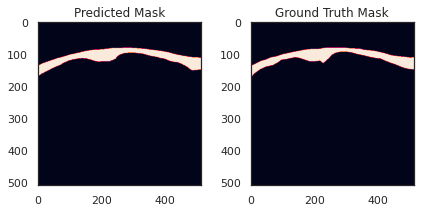

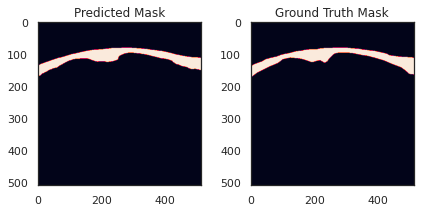

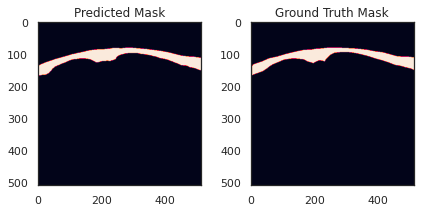

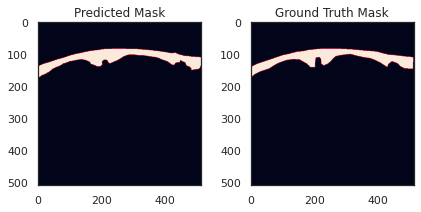

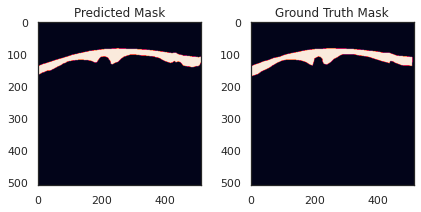

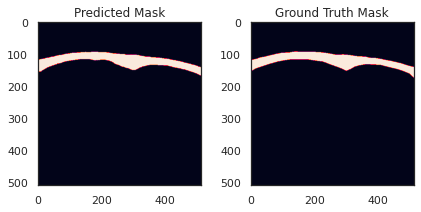

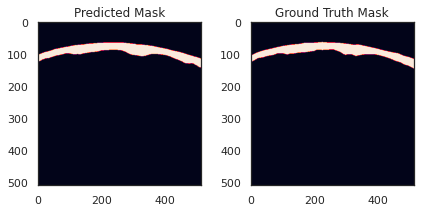

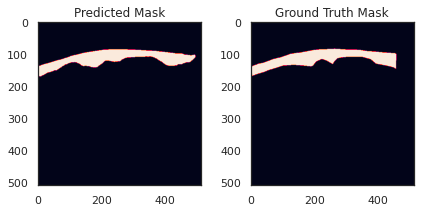

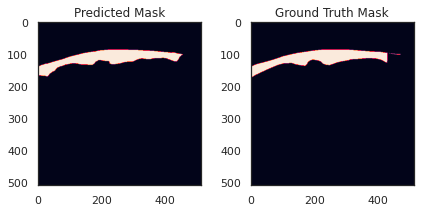

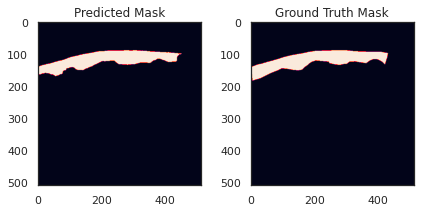

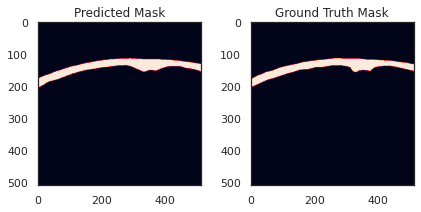

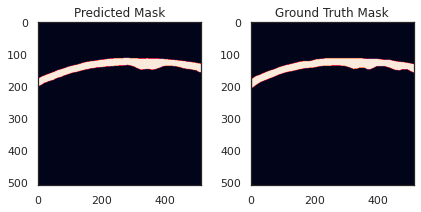

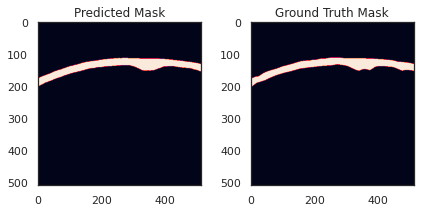

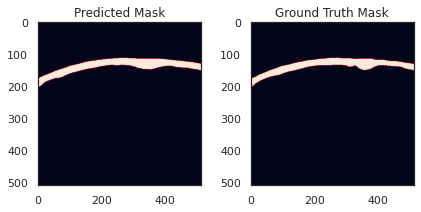

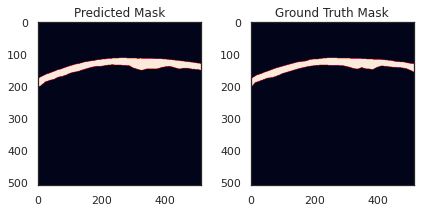

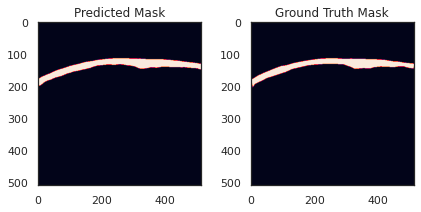

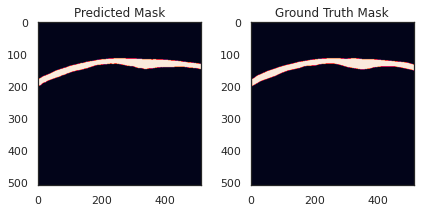

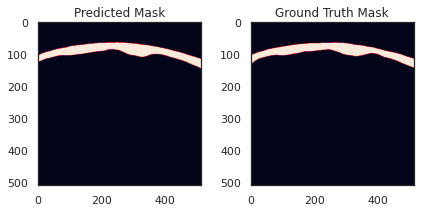

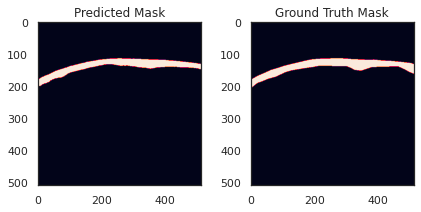

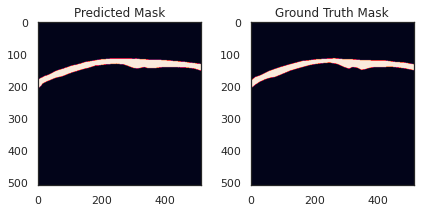

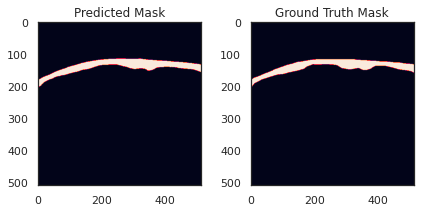

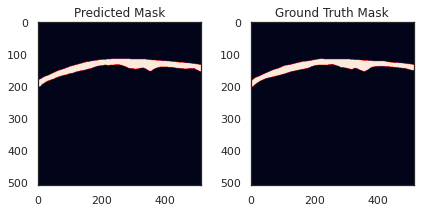

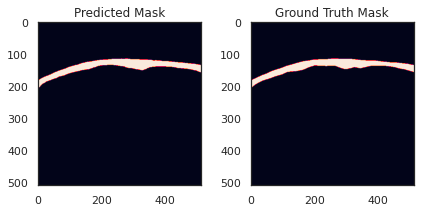

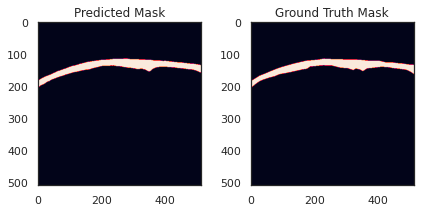

In [25]:
verbose = True

preds = []
outputs = []
model.train(False)
with torch.no_grad():
    for step, (image, mask) in enumerate(test_dataset, 1):
        image = torch.Tensor(image).unsqueeze(0).to(cfg.DEVICE).float()

        pred = model(image) > 0.5
        pred = pred[0][0].cpu().detach().numpy()
        
        # Post processing.
        #pred = remove_small_components(pred, 100)
        
        # Visualization.
        fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize = (7, 3))
        ax_0.set_title("Predicted Mask")
        ax_0.imshow(pred)
        ax_1.set_title("Ground Truth Mask")
        ax_1.imshow(mask[0])
        plt.show()


In [27]:
state = {
    "model_state_dict": model.cpu().state_dict()
}

torch.save(state, "./model_0_cpu.pth")